In [1]:
import yfinance as yf
import pandas as pd

In [2]:
nifty50 = yf.Ticker('^NSEI')
nifty50 = nifty50.history(start='2014-01-01', end='2024-10-15')
#the volume here is (The actual volume / 1000)

In [3]:
del nifty50["Dividends"]
del nifty50["Stock Splits"]

nifty50["Tommorow"] = nifty50['Close'].shift(-1)
nifty50['Target'] = (nifty50['Tommorow'] > nifty50['Close']).astype(int)
nifty50 = nifty50.drop(nifty50.index[-1])

In [4]:
nifty50

,Open,High,Low,Close,Volume,Tommorow,Target
Date,,,,,,,
2014-01-02 00:00:00+05:30,6301.250000,6358.299805,6211.299805,6221.149902,158100,6211.149902,0
2014-01-03 00:00:00+05:30,6194.549805,6221.700195,6171.250000,6211.149902,139000,6191.450195,0
2014-01-06 00:00:00+05:30,6220.850098,6224.700195,6170.250000,6191.450195,118300,6162.250000,0
2014-01-07 00:00:00+05:30,6203.899902,6221.500000,6144.750000,6162.250000,138600,6174.600098,1
2014-01-08 00:00:00+05:30,6178.049805,6192.100098,6160.350098,6174.600098,146900,6168.350098,0
...,...,...,...,...,...,...,...
2024-10-07 00:00:00+05:30,25084.099609,25143.000000,24694.349609,24795.750000,374300,25013.150391,1
2024-10-08 00:00:00+05:30,24832.199219,25044.000000,24756.800781,25013.150391,333200,24981.949219,0
2024-10-09 00:00:00+05:30,25065.800781,25234.050781,24947.699219,24981.949219,290600,24998.449219,1


In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=200,  # Increase split threshold
    max_depth=10,  # Limit depth
    class_weight='balanced',  # Handle imbalance
    random_state=1
)


In [6]:
train = nifty50.iloc[:-100]
test = nifty50.iloc[-100:]

predictors = ["High", "Low", "Open", "Volume", "Close"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=200, random_state=1)

In [7]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [8]:
preds = pd.Series(preds, index=test.index)
precision_score(test['Target'], preds)

1.0

<Axes: xlabel='Date'>

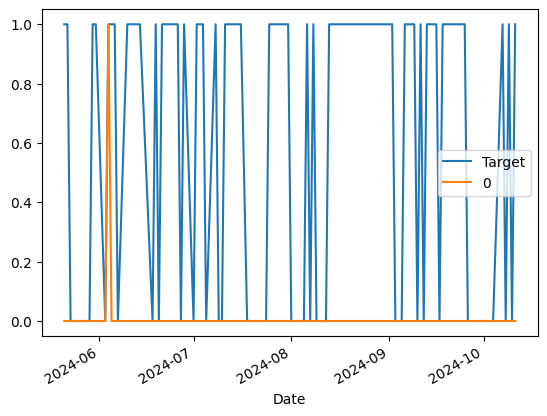

In [22]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [10]:
#BackTwsting

def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


data = nifty50
def backtest(data, model, predictors, start=1250, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)



In [11]:
predictions = backtest(nifty50, model, predictors)

In [12]:
predictions["Predictions"].value_counts()

Predictions
0    878
1    517
Name: count, dtype: int64

In [13]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5667311411992263

In [14]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty50.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    nifty50[ratio_column] = nifty50["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    nifty50[trend_column] = nifty50.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [15]:
nifty50 = nifty50.dropna()

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
predictions = backtest(nifty50, model, new_predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    389
1.0      6
Name: count, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.8333333333333334

In [19]:
import joblib
joblib.dump(model, 'predictor.pkl')


['predictor.pkl']

In [23]:

new_data = pd.DataFrame({
    'Open': [100],
    'High': [110],
    'Low': [95],
    'Volume': [1000000],
    'Close': [105]
})

# Calculate new predictors for the new data
horizons = [2, 5, 60, 250, 1000]
for horizon in horizons:
    rolling_average = new_data['Close'].mean()  # Simplified for single row
    new_data[f'Close_Ratio_{horizon}'] = new_data['Close'] / rolling_average
    new_data[f'Trend_{horizon}'] = 1  # Assuming 'Target' is 1 for trend calculation

# List all new predictors
new_predictors = [f'Close_Ratio_{horizon}' for horizon in horizons] + [f'Trend_{horizon}' for horizon in horizons]

# Make predictions
preds = model.predict(new_data[new_predictors])
print(preds)



ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
